# Fine Wine
10-315 Final Project

Team members: Run Qian Gong (runqiang), James Kim (gyeongwk), Lucas Zheng (lyzheng)


## Table of Contents
*   [Setup and Data](#setup)
*   [Model](#model)
    - [Helper Functions](#helper)
    - [Logistic Regression](#logistic)
    - [Neural Networks](#neural)
        * [Experiment](#exp2)
  

### Setup and Data <a class="anchor" name="setup"></a>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
train = False

In [ ]:
# Read data from github
df = pd.read_csv('https://raw.githubusercontent.com/lzheng25/10-315-Fine-Wine/main/winequality-red.csv')
# Here is a preview of the data
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# Normalize data
df.iloc[:, :-1] = (df.iloc[:, :-1] - df.iloc[:, :-1].mean()) / df.iloc[:, :-1].std()

# Split dataset into train and test sets
df_train = df.sample(frac = 0.8)
df_valid = df.drop(df_train.index)

# Split dataset into X and y
X_train = df_train[list(df_train.columns)[:-1]].to_numpy()
y_train = df_train["quality"].to_numpy()
X_valid = df_valid[list(df_train.columns)[:-1]].to_numpy()
y_valid = df_valid["quality"].to_numpy()

# Convert y to binary classification labels 0 or 1
# "Good" (label = 1): wine quality > 6.5
# "Bad" (label = 0): win quality < 6.5
y_train = (y_train > 6.5).astype(int)
y_valid = (y_valid > 6.5).astype(int)

print("Number of training samples: ", X_train.shape[0])
print("Number of good datapoints in training set: ", np.sum(y_train))
print("Number of valid samples: ", X_valid.shape[0])
print("Number of good datapoints in valid set: ", np.sum(y_valid))

Number of training samples:  1279
Number of good datapoints in training set:  166
Number of valid samples:  320
Number of good datapoints in valid set:  51


In [ ]:
# Convert dataset to tensors and create DataLoader
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_valid_t = torch.tensor(X_valid, dtype=torch.float32)

y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size = 1)
valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t), batch_size = 1)

### Model <a class="anchor" name="model"></a>

#### Helper Functions <a class="anchor" name="helper"></a>

In [ ]:
# Evaluate the average loss and accuracy of current model
# Source: 10-315 HW7 (Virtue)
def eval_DL(model, dl, lossfn):
  with torch.no_grad():
    lossSum = 0
    nCorrect = 0
    for x, y in dl:
      yhat = model(x)

      # compute the loss and add to total (multiply by batch-size to make mean into sum)
      # by default, loss functions compute means of losses over batches
      lossSum += lossfn(yhat, y) * x.shape[0]

      # compute the number of correct and update
      predictions = torch.where(yhat > 0.5, 1, 0)
      truth = torch.where(y > 0.5, 1, 0)
      nCorrect += torch.sum(predictions == truth)

    numSamples = len(dl.dataset)
    avgLoss = lossSum / numSamples
    acc = nCorrect / numSamples
  return avgLoss.item(), acc.item()

def eval(model, trainDL, validDL, lossfn):
  trainLoss, trainAcc = eval_DL(model, trainDL, lossfn)
  validLoss, validAcc = eval_DL(model, validDL, lossfn)
  return trainLoss, trainAcc, validLoss, validAcc

In [ ]:
# Plot loss and accuracy vs epoch 
# Source: 10-315 HW7 (Virtue)
def plotStatistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
  fig, axes = plt.subplots(1,2)
  xdata = np.arange(epochs+1)
  
  # plot the losses
  axis = axes[0]
  axis.plot(xdata, trainLosses, label="Train")
  axis.plot(xdata, validLosses, label="Valid")
  axis.set_xlabel("# Epochs")
  axis.set_ylabel("Average Loss")
  axis.set_title("Loss")
  axis.grid()
  axis.legend()
  
  # plot the accuracies
  axis = axes[1]
  axis.plot(xdata, trainAccs, label="Train")
  axis.plot(xdata, validAccs, label="Valid")
  axis.set_xlabel("# Epochs")
  axis.set_ylabel("Accuracy")
  axis.set_title("Accuracy")
  axis.grid()
  axis.legend()

  fig.tight_layout()

#### Logistic Regression <a class="anchor" name="logistic"></a>

In [ ]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, 1)

  def forward(self, x):
    outputs = torch.sigmoid(self.linear(x))
    return outputs

In [ ]:
def train_model(model, train_loader,valid_loader, learning_rate, num_epochs):
  criterion = nn.BCELoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  
  trainLosses = []
  trainAccs   = []
  validLosses = []
  validAccs   = []
  train_loss, train_acc,valid_loss, valid_acc = eval(model, train_loader,valid_loader ,criterion)
  trainLosses.append(train_loss)
  trainAccs.append(train_acc)
  validLosses.append(valid_loss)
  validAccs.append(valid_acc)
  
  for epoch in range(num_epochs):
    for x, y in train_loader:
      optimizer.zero_grad()
      y_pred = model(x)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()

    train_loss, train_acc,valid_loss, valid_acc = eval(model, train_loader,valid_loader ,criterion)
    trainLosses.append(train_loss)
    trainAccs.append(train_acc)
    validLosses.append(valid_loss)
    validAccs.append(valid_acc)
  return trainLosses,trainAccs,validLosses,validAccs

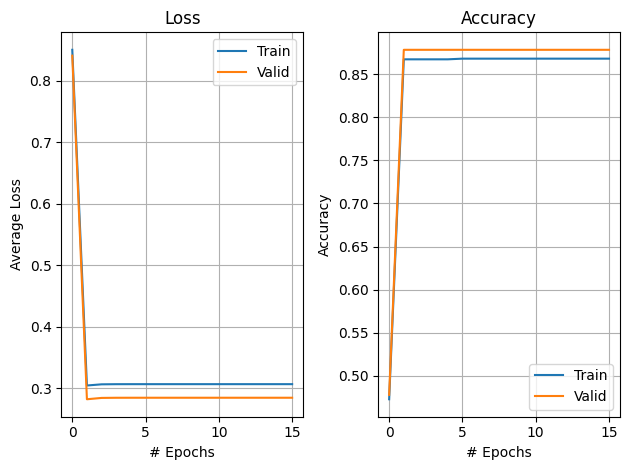

In [ ]:
# Hyperparamters
n_features = 11
learning_rate = 0.1
n_epochs = 15

if train == True : 
  model = LogisticRegression(n_features)
  trainLosses,trainAccs,validLosses,validAccs = train_model(model, train_loader, valid_loader, learning_rate, n_epochs)
  plotStatistics(n_epochs, trainLosses,trainAccs,validLosses,validAccs)
else : 
  model = LogisticRegression(n_features)
  !curl -s https://raw.githubusercontent.com/lzheng25/10-315-Fine-Wine/main/log_reg.pt --output log_reg.pt
  model.load_state_dict(torch.load('log_reg.pt'))

  avg_loss, acc = eval_DL(model, valid_loader, nn.BCELoss())
  print(f"Average Loss: {avg_loss}")
  print(f"Accuracy: {acc}")

In [ ]:
#Saving Model parameters
# torch.save(model.state_dict(), "log_reg.pt")

#### Neural Networks <a class="anchor" name="neural"></a>

In [ ]:
class WineNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(11, 10)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(10, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    z = self.relu(self.linear1(x))
    return self.sigmoid(self.linear2(z))

In [ ]:
def model_train(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01):
  loss_fn = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  trainLosses = []
  trainAccs   = []
  validLosses = []
  validAccs   = []
  
  train_loss, train_acc,valid_loss, valid_acc = eval(model, train_loader, valid_loader, loss_fn)
  trainLosses.append(train_loss)
  trainAccs.append(train_acc)
  validLosses.append(valid_loss)
  validAccs.append(valid_acc)

  for epoch in range(num_epochs):
    for x,y in train_loader:
      pred = model(x)
      loss = loss_fn(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss, train_acc,valid_loss, valid_acc = eval(model, train_loader, valid_loader, loss_fn)
    trainLosses.append(train_loss)
    trainAccs.append(train_acc)
    validLosses.append(valid_loss)
    validAccs.append(valid_acc)
  
  return trainLosses, trainAccs, validLosses, validAccs

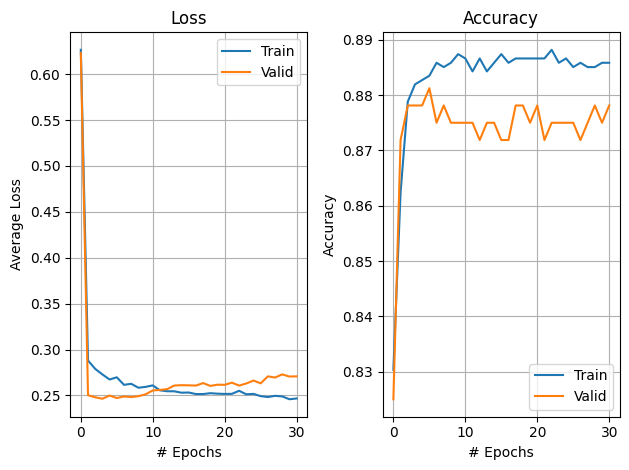

In [ ]:
# Hyperparameters
num_epochs = 30
learning_rate = 0.01

if train == True : 
  model = WineNet()
  trainLosses, trainAccs, validLosses, validAccs = model_train(model, train_loader, valid_loader, num_epochs, learning_rate)
  plotStatistics(num_epochs, trainLosses,trainAccs,validLosses,validAccs)
else : 
  model = WineNet()
  !curl -s https://raw.githubusercontent.com/lzheng25/10-315-Fine-Wine/main/wine_net.pt --output wine_net.pt
  model.load_state_dict(torch.load('wine_net.pt'))

  avg_loss, acc = eval_DL(model, valid_loader, nn.BCELoss())
  print(f"Average Loss: {avg_loss}")
  print(f"Accuracy: {acc}")

In [ ]:
# Saving Model parameters
# torch.save(model.state_dict(), "wine_net.pt")

##### Experiment <a class="anchor" name="exp2"></a>

In [ ]:
class SimpleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(11, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear1(x))

class ReLUNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(11, 10)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(10, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    z = self.relu(self.linear1(x))
    return self.sigmoid(self.linear2(z))

class TanhNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(11, 10)
    self.tanh = nn.Tanh()
    self.linear2 = nn.Linear(10, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    z = self.tanh(self.linear1(x))
    return self.sigmoid(self.linear2(z))

In [ ]:
def test_multiple_nets():
  simplenet = SimpleNet()
  relunet = ReLUNet()
  tanhnet = TanhNet()

  # Hyperparameters
  num_epochs = 20
  learning_rate = 0.01

  print("Simple, no-hidden layer")
  trainLosses, trainAccs, validLosses, validAccs = model_train(simplenet, train_loader, valid_loader, num_epochs, learning_rate)
  plotStatistics(num_epochs, trainLosses, trainAccs, validLosses, validAccs)

  print("One hidden layer with ReLU activation")
  trainLosses, trainAccs, validLosses, validAccs = model_train(relunet, train_loader, valid_loader, num_epochs, learning_rate)
  plotStatistics(num_epochs, trainLosses, trainAccs, validLosses, validAccs)

  print("One hidden layer with Tanh activation")
  trainLosses, trainAccs, validLosses, validAccs = model_train(tanhnet, train_loader, valid_loader, num_epochs, learning_rate)
  plotStatistics(num_epochs, trainLosses, trainAccs, validLosses, validAccs)

def test_learning_rates():
  # Hyperparameters
  num_epochs = 20
  learning_rates = [0.1, 0.01, 0.001]

  for lr in learning_rates:
    relunet = ReLUNet()
    print("Learning rate: ", lr)
    trainLosses, trainAccs, validLosses, validAccs = model_train(relunet, train_loader, valid_loader, num_epochs, lr)
    plotStatistics(num_epochs, trainLosses, trainAccs, validLosses, validAccs)

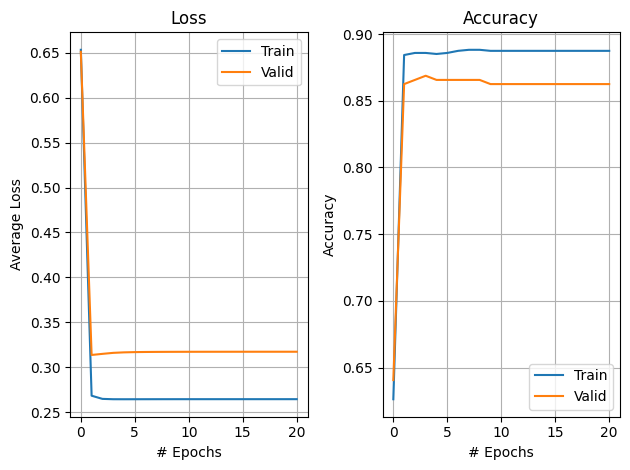

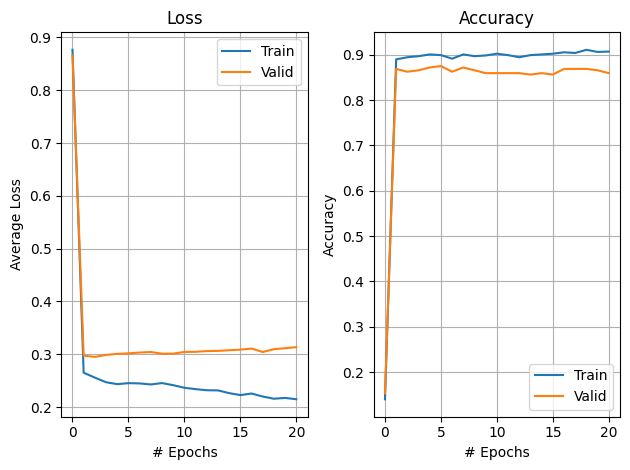

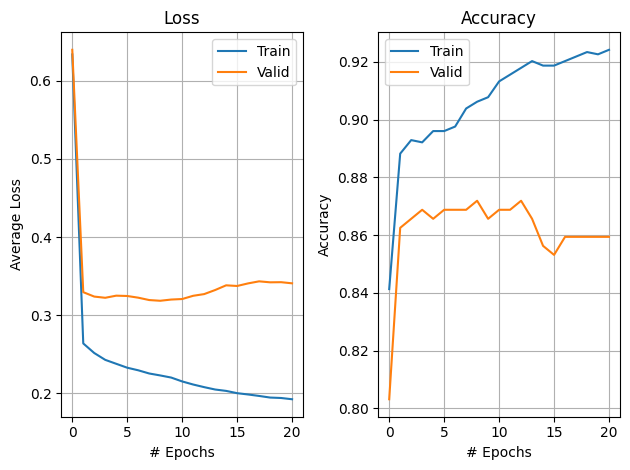

In [ ]:
test_multiple_nets()

Learning rate:  0.1
Learning rate:  0.01
Learning rate:  0.001


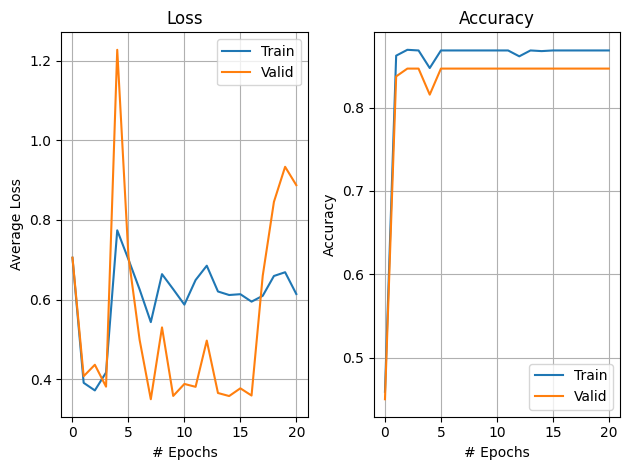

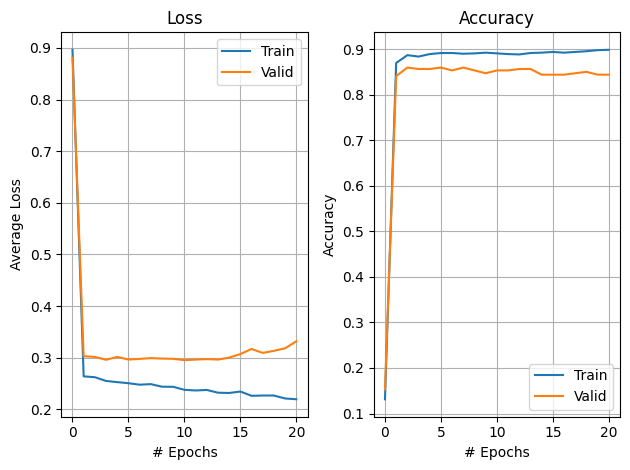

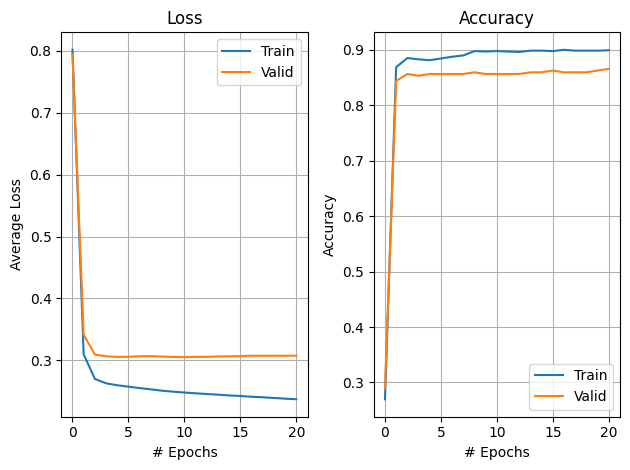

In [ ]:
test_learning_rates()